# Kunden-Segmentierungsanalyse für TravelTide

## 1. Datenvorbereitung und Vorverarbeitung

### 1.1 Initiale Einrichtung

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder
import warnings

warnings.filterwarnings('ignore')

### 1.2 Datenladung und Bereinigung

In [95]:
# Datensatz laden
df = pd.read_csv('data/users_real.csv', sep=';')

# Ausreißer bei Hotelausgaben entfernen
df = df[df['real_avg_money_spent_hotel'] <= 190]

# Erste Datenexploration
print(f"Datensatzgröße: {df.shape}")
print("\nErste 5 Zeilen:")
print(df.head())
print("\nDateninformationen:")
print(df.info())
print("\nDeskriptive Statistik:")
print(df.describe())

Datensatzgröße: (5233, 26)

Erste 5 Zeilen:
   user_id  total_sessions  total_none_trips  total_cancellations  real_trips  \
0    23557               8                 6                    0           2   
1    94883               8                 6                    0           2   
2   101486               8                 6                    0           2   
4   118043               8                 3                    0           5   
5   120851               8                 7                    0           1   

   real_flights  real_hotels_booked  real_avg_flight_discount  \
0             0                   2                       0.0   
1             4                   2                       0.0   
2             2                   2                       0.0   
4             6                   4                       0.0   
5             2                   1                       0.0   

   real_avg_hotel_discount  avg_page_clicks  ...  age  gender  home_country  \

### 1.3 Daten Vorbereitung: Fillna, Encoding, Skalierung

In [96]:
# Merkmalsauswahl und Entfernung kategorialer Variablen
features_row = df.drop(['home_country', 'home_city', 'home_airport', 'gender'], axis=1)

# Fehlende Werte behandeln
features_row.fillna(features_row.median(), inplace=True)

# One-Hot-Encoding für kategoriale Variablen
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_cols = ['has_children', 'married']
encoded = pd.DataFrame(
    encoder.fit_transform(features_row[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols),
    index=features_row.index
)

# Kombinierte Merkmale
users_encoded_oh = features_row.drop(columns=categorical_cols).copy()
features = pd.concat([users_encoded_oh, encoded], axis=1)

# Skalierung der Merkmale
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

### 1.4. Hilfsfunktionen für die Clustering-Methoden

In [97]:
def plot_clusters(data, labels, title, method_name):
    """Visualisierung der Cluster mit t-SNE"""
    plt.figure(figsize=(12, 6))
    tsne = TSNE(n_components=2, random_state=42)
    tsne_data = tsne.fit_transform(data)
    plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.title(f'{title} (Methode: {method_name})')
    plt.colorbar()
    plt.show()

def elbow_method(data, max_k=10):
    """Bestimmung der optimalen Clusteranzahl für KMeans"""
    distortions = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), distortions, marker='o')
    plt.xlabel('Anzahl Cluster')
    plt.ylabel('Distortion')
    plt.title('Elbow-Methode')
    plt.show()

def find_optimal_eps(data, n_neighbors=5):
    """Bestimmung des optimalen EPS-Parameters für DBSCAN"""
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(data)
    distances, _ = nbrs.kneighbors(data)
    distances = np.sort(distances[:, n_neighbors - 1], axis=0)
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.xlabel('Punkte sortiert nach Distanz')
    plt.ylabel(f'{n_neighbors}-te Nachbar-Distanz')
    plt.title('K-Distanz-Graph')
    plt.show()

def find_optimal_pca_components(data, threshold=0.95):
    """Bestimmung der optimalen PCA-Komponenten"""
    pca = PCA().fit(data)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    plt.figure(figsize=(10, 6))
    plt.plot(explained_variance)
    plt.axhline(y=threshold, color='r', linestyle='--')
    plt.xlabel('Anzahl Komponenten')
    plt.ylabel('Kumulierte erklärte Varianz')
    plt.title('PCA Explained Variance')
    plt.show()
    n_components = np.argmax(explained_variance >= threshold) + 1
    print(f"Optimale Anzahl PCA-Komponenten (Threshold={threshold}): {n_components}")
    return n_components

## 2. Durchführung und Auswertung des Clusterings


### 2.1 KMeans-Clustering
1. KMeans ohne PCA

| Cluster | Anzahl Nutzer | Anteil (%) |
|---------|---------------|------------|
| 0       |          1519 |       29.0 |
| 1       |          1482 |       28.3 |
| 2       |           697 |       13.3 |
| 3       |          1535 |       29.3 |

2. KMeans mit PCA

| Cluster | Anzahl Nutzer | Anteil (%) |
|---------|---------------|------------|
| 0       |          1521 |       29.1 |
| 1       |          1504 |       28.7 |
| 2       |          1520 |       29.0 |
| 3       |           688 |       13.1 |


KMeans ohne PCA:


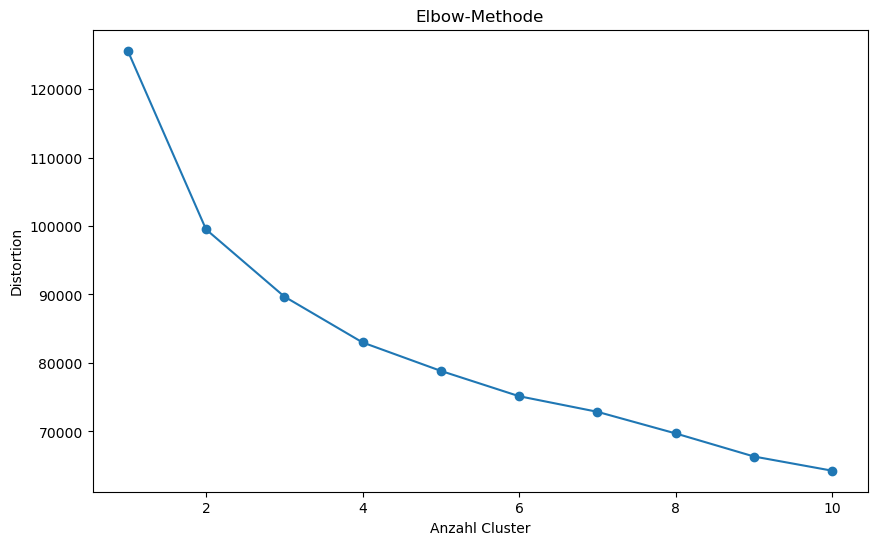

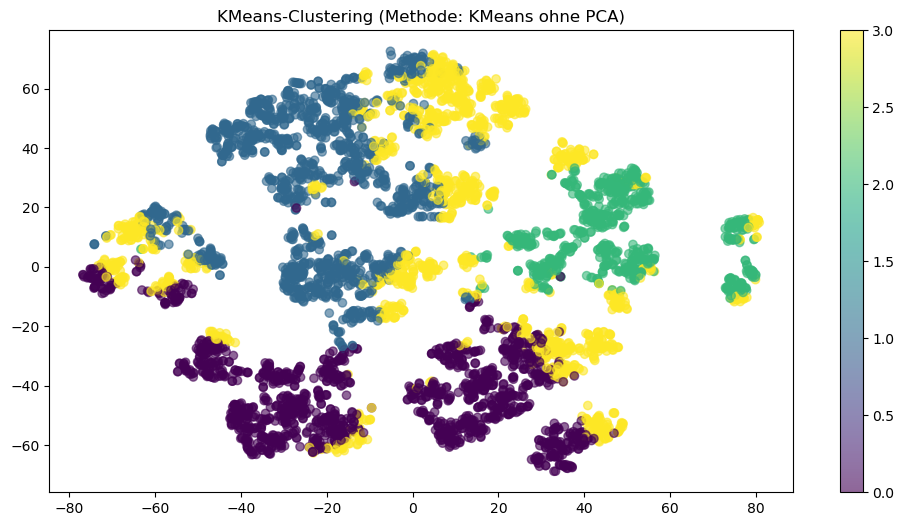

,Cluster,Anzahl Nutzer,Anteil (%)
0,0,1519,29.0
1,1,1482,28.3
2,2,697,13.3
3,3,1535,29.3



KMeans mit PCA:


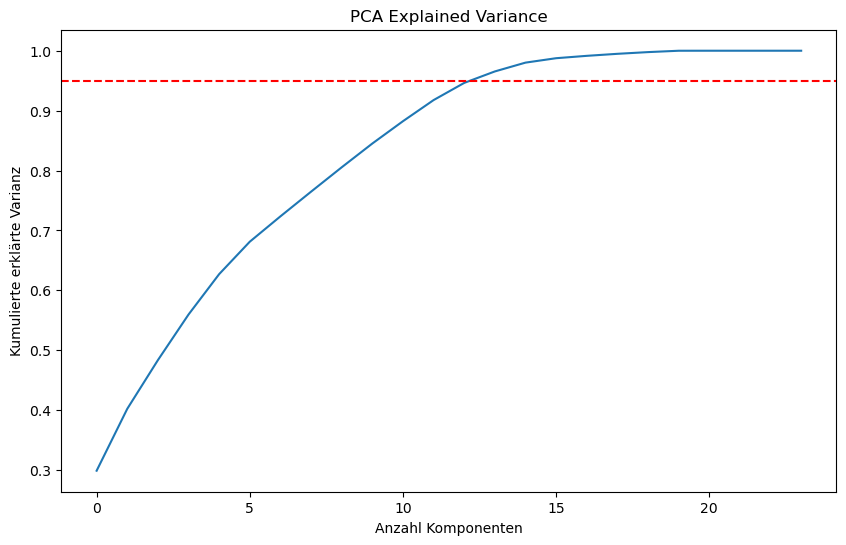

Optimale Anzahl PCA-Komponenten (Threshold=0.95): 14


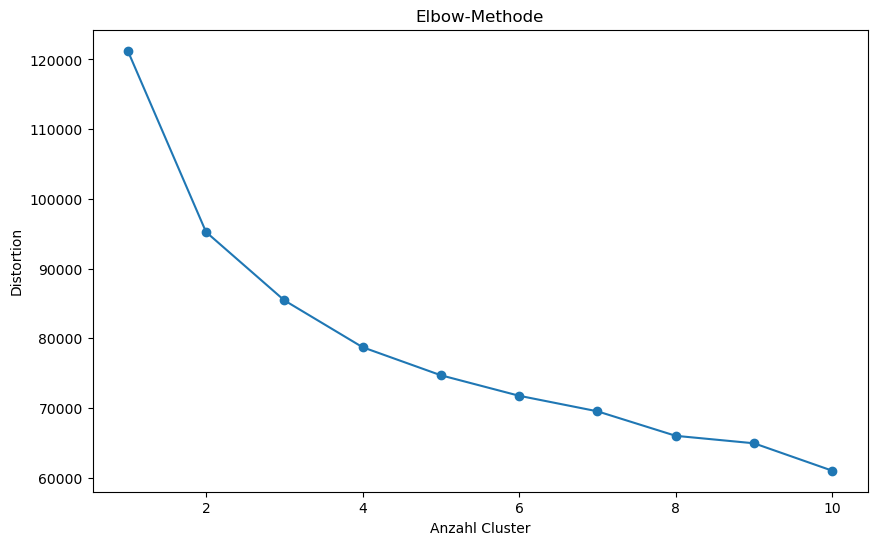

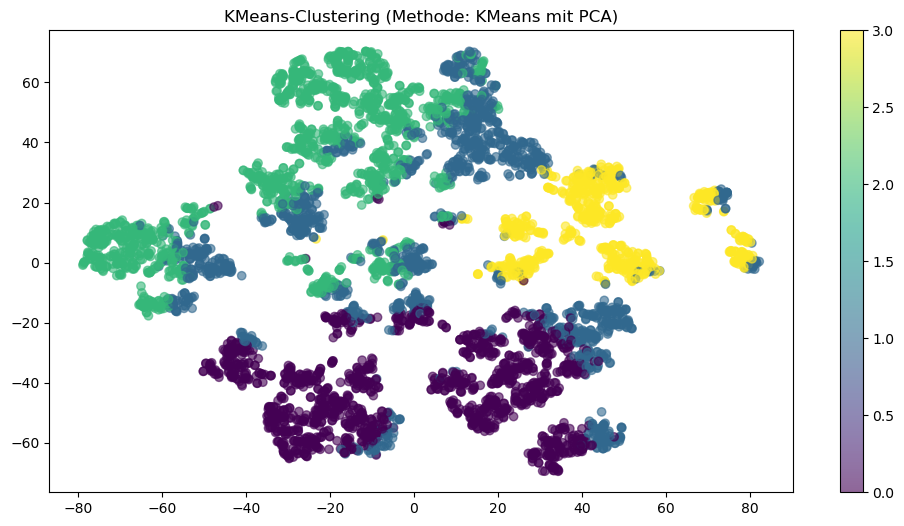

,Cluster,Anzahl Nutzer,Anteil (%)
0,0,1521,29.1
1,2,1520,29.0
2,1,1504,28.7
3,3,688,13.1


In [98]:
# KMeans ohne PCA
print("\nKMeans ohne PCA:")
elbow_method(scaled_features)
optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_features)

plot_clusters(scaled_features, kmeans_labels, 'KMeans-Clustering', 'KMeans ohne PCA')

# Cluster-Statistiken anzeigen
cluster_kmeans_counts = pd.Series(kmeans_labels).value_counts().sort_index()
cluster_kmeans_stats = pd.DataFrame({
    'Cluster': cluster_kmeans_counts.index,
    'Anzahl Nutzer': cluster_kmeans_counts.values,
    'Anteil (%)': (cluster_kmeans_counts.values / len(kmeans_labels) * 100).round(1)
})
display(cluster_kmeans_stats)

# KMeans mit PCA
print("\nKMeans mit PCA:")
n_components = find_optimal_pca_components(scaled_features)
pca = PCA(n_components=n_components)
pca_features = pca.fit_transform(scaled_features)

elbow_method(pca_features)
optimal_k_pca = 4

kmeans_pca = KMeans(n_clusters=optimal_k_pca, random_state=42)
kmeans_pca_labels = kmeans_pca.fit_predict(pca_features)
features_row['cluster'] = kmeans_pca_labels
plot_clusters(pca_features, kmeans_pca_labels, 'KMeans-Clustering', 'KMeans mit PCA')

# PCA-Cluster-Statistiken anzeigen
pca_cluster_kmeans_counts = pd.Series(kmeans_pca_labels).value_counts().sort_index()
pca_cluster_kmeans_stats = pd.DataFrame({
    'Cluster': pca_cluster_kmeans_counts.index,
    'Anzahl Nutzer': pca_cluster_kmeans_counts.values,
    'Anteil (%)': (pca_cluster_kmeans_counts.values / len(kmeans_pca_labels) * 100).round(1)
})

clusters_sorted = pca_cluster_kmeans_stats.sort_values(
    by='Anteil (%)', 
    ascending=False
).reset_index(drop=True)
display(clusters_sorted)

### 2.2 DBSCAN-Clustering
1. DBSCAN ohne PCA

| Cluster        | Anzahl Nutzer | Anteil (%) |
|----------------|---------------|------------|
| Rauschen (-1)  |           154 |        2.9 |
| Cluster 0      |          4537 |       86.7 |
| Cluster 1      |           412 |        7.9 |
| Cluster 2      |            53 |        1.0 |
| Cluster 3      |            58 |        1.1 |
| Cluster 4      |             4 |        0.1 |
| Cluster 5      |             7 |        0.1 |
| Cluster 6      |             4 |        0.1 |
| Cluster 7      |             4 |        0.1 |

2. DBSCAN mit PCA

| Cluster        | Anzahl Nutzer | Anteil (%) |
|----------------|---------------|------------|
| Rauschen (-1)  |           387 |        7.4 |
| Cluster 0      |             5 |        0.1 |
| Cluster 1      |             5 |        0.1 |
| Cluster 2      |           828 |       15.8 |
| Cluster 3      |          1801 |       34.4 |
| Cluster 4      |           618 |       11.8 |
| Cluster 5      |          1145 |       21.9 |
| Cluster 6      |           122 |        2.3 |
| Cluster 7      |            99 |        1.9 |
| Cluster 8      |            58 |        1.1 |
| Cluster 9      |            25 |        0.5 |
| Cluster 10     |            18 |        0.3 |
| Cluster 11     |            60 |        1.1 |
| Cluster 12     |             6 |        0.1 |
| Cluster 13     |             9 |        0.2 |
| Cluster 14     |             7 |        0.1 |
| Cluster 15     |            10 |        0.2 |
| Cluster 16     |             6 |        0.1 |
| Cluster 17     |             5 |        0.1 |
| Cluster 18     |             9 |        0.2 |
| Cluster 19     |             6 |        0.1 |
| Cluster 20     |             4 |        0.1 |



DBSCAN ohne PCA:


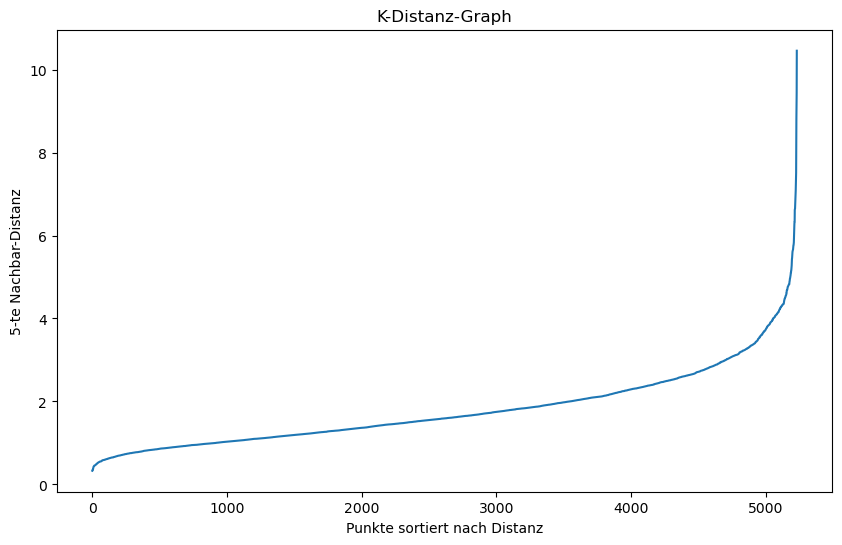

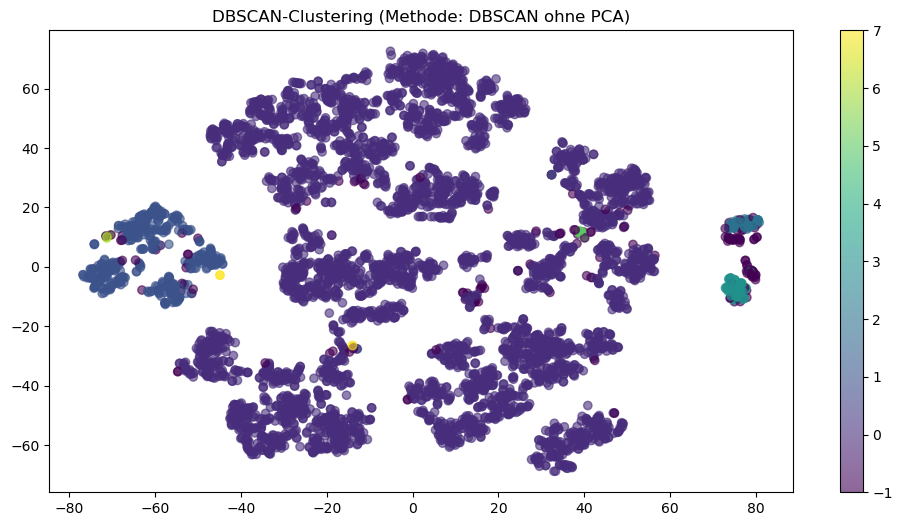


Nutzerverteilung über Cluster:
      Cluster  Anzahl Nutzer  Anteil (%)
Rauschen (-1)            154         2.9
    Cluster 0           4537        86.7
    Cluster 1            412         7.9
    Cluster 2             53         1.0
    Cluster 3             58         1.1
    Cluster 4              4         0.1
    Cluster 5              7         0.1
    Cluster 6              4         0.1
    Cluster 7              4         0.1

DBSCAN mit PCA:


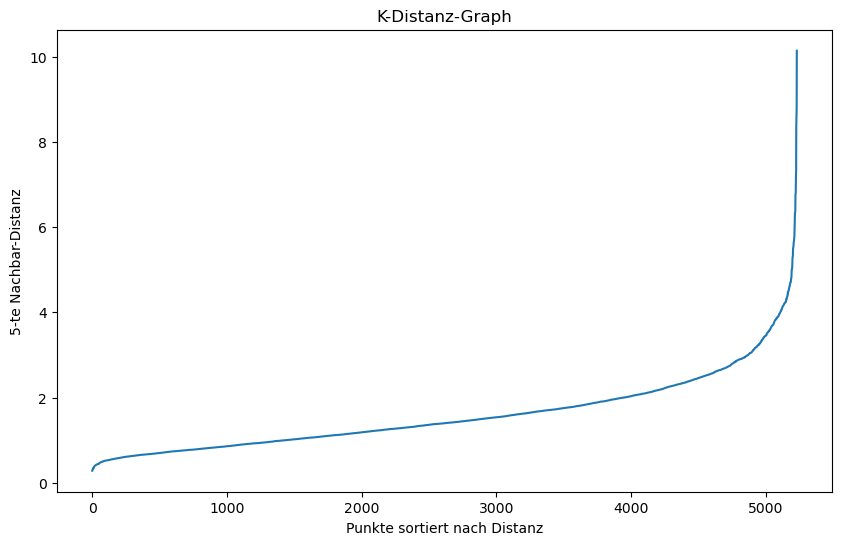

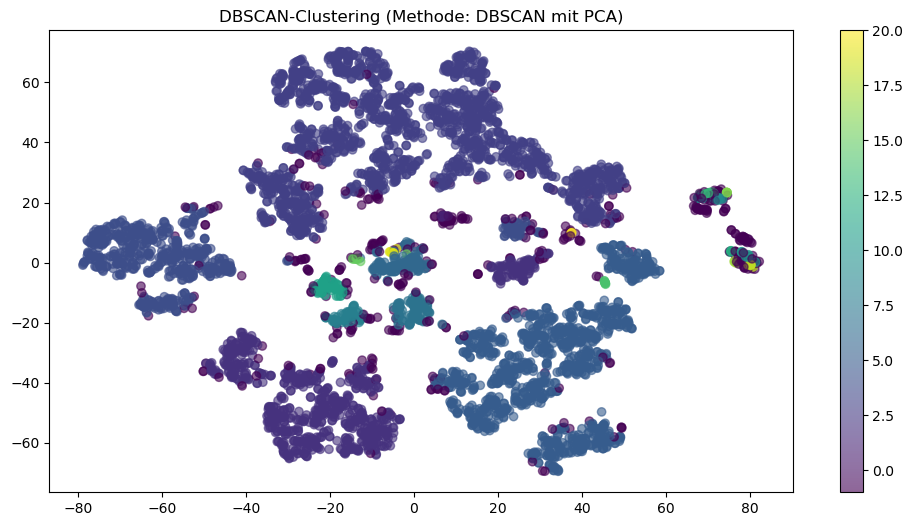


Nutzerverteilung über PCA-basierte Cluster:
      Cluster  Anzahl Nutzer  Anteil (%)
Rauschen (-1)            387         7.4
    Cluster 0              5         0.1
    Cluster 1              5         0.1
    Cluster 2            828        15.8
    Cluster 3           1801        34.4
    Cluster 4            618        11.8
    Cluster 5           1145        21.9
    Cluster 6            122         2.3
    Cluster 7             99         1.9
    Cluster 8             58         1.1
    Cluster 9             25         0.5
   Cluster 10             18         0.3
   Cluster 11             60         1.1
   Cluster 12              6         0.1
   Cluster 13              9         0.2
   Cluster 14              7         0.1
   Cluster 15             10         0.2
   Cluster 16              6         0.1
   Cluster 17              5         0.1
   Cluster 18              9         0.2
   Cluster 19              6         0.1
   Cluster 20              4         0.1

Durchschnit

In [99]:
# DBSCAN ohne PCA
print("\nDBSCAN ohne PCA:")
find_optimal_eps(scaled_features)
eps = 3.5
min_samples = 4

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(scaled_features)
plot_clusters(scaled_features, dbscan_labels, 'DBSCAN-Clustering', 'DBSCAN ohne PCA')

# DBSCAN-Ergebnisse anzeigen
cluster_counts = pd.Series(dbscan_labels).value_counts().sort_index()
cluster_stats = pd.DataFrame({
    'Cluster': cluster_counts.index,
    'Anzahl Nutzer': cluster_counts.values,
    'Anteil (%)': (cluster_counts.values / len(dbscan_labels) * 100).round(1)
})
cluster_stats['Cluster'] = cluster_stats['Cluster'].apply(
    lambda x: 'Rauschen (-1)' if x == -1 else f'Cluster {x}')
print("\nNutzerverteilung über Cluster:")
print(cluster_stats.to_string(index=False))

# DBSCAN mit PCA
print("\nDBSCAN mit PCA:")
find_optimal_eps(pca_features)
eps_pca = 2.5

dbscan_pca = DBSCAN(eps=eps_pca, min_samples=min_samples)
dbscan_pca_labels = dbscan_pca.fit_predict(pca_features)
plot_clusters(pca_features, dbscan_pca_labels, 'DBSCAN-Clustering', 'DBSCAN mit PCA')

# PCA-DBSCAN-Ergebnisse anzeigen
pca_cluster_counts = pd.Series(dbscan_pca_labels).value_counts().sort_index()
pca_cluster_stats = pd.DataFrame({
    'Cluster': pca_cluster_counts.index,
    'Anzahl Nutzer': pca_cluster_counts.values,
    'Anteil (%)': (pca_cluster_counts.values / len(dbscan_pca_labels) * 100).round(1)
})
pca_cluster_stats['Cluster'] = pca_cluster_stats['Cluster'].apply(
    lambda x: 'Rauschen (-1)' if x == -1 else f'Cluster {x}')
print("\nNutzerverteilung über PCA-basierte Cluster:")
print(pca_cluster_stats.to_string(index=False))

# Optional: Hauptkomponenten-Analyse pro Cluster
if isinstance(pca_features, np.ndarray):
    pca_columns = [f'PC{i+1}' for i in range(pca_features.shape[1])]
    pca_df = pd.DataFrame(pca_features, columns=pca_columns)
    pca_df['Cluster'] = dbscan_pca_labels

    print("\nDurchschnittliche PCA-Werte pro Cluster:")
    print(pca_df.groupby('Cluster').mean().round(2))

# 3. Ergebnisvergleich

Vergleich der Clustering Methoden

| Methode           | Silhouette-Score | Cluster-Anzahl | Bewertung               |
|-------------------|------------------|----------------|-------------------------|
| KMeans ohne PCA   | 0.130803         | 4              | ⭐⭐ Beste Balance      |
| KMeans mit PCA    | 0.139733         | 4              | ⭐⭐⭐ Bester Score     |
| DBSCAN ohne PCA   | 0.087455         | 9              | ⭐ Akzeptabel           |
| DBSCAN mit PCA    | 0.058176         | 22             | ❌ Zu viele Cluster     |


=> **Best Model: KMeans mit PCA mit Silhouette-Score 0.140**



In [100]:

## Vergleich der Ergebnisse
def evaluate_clustering(data, labels):
    if len(np.unique(labels)) > 1:
        return silhouette_score(data, labels)
    return None

# Bewertung aller Clustering-Methoden
results = {
    'Methode': ['KMeans ohne PCA', 'KMeans mit PCA', 'DBSCAN ohne PCA', 'DBSCAN mit PCA'],
    'Silhouette-Score': [
        evaluate_clustering(scaled_features, kmeans_labels),
        evaluate_clustering(pca_features, kmeans_pca_labels),
        evaluate_clustering(scaled_features, dbscan_labels),
        evaluate_clustering(pca_features, dbscan_pca_labels)
    ],
    'Anzahl Cluster': [
        len(np.unique(kmeans_labels)),
        len(np.unique(kmeans_pca_labels)),
        len(np.unique(dbscan_labels)),
        len(np.unique(dbscan_pca_labels))
    ]
}

results_df = pd.DataFrame(results)
print("\nVergleich der Clustering-Methoden:")
display(results_df)



Vergleich der Clustering-Methoden:


,Methode,Silhouette-Score,Anzahl Cluster
0,KMeans ohne PCA,0.130803,4
1,KMeans mit PCA,0.139733,4
2,DBSCAN ohne PCA,0.087455,9
3,DBSCAN mit PCA,0.058176,22


In [101]:
# Methodenauswahl
best_method_idx = np.nanargmax(results_df['Silhouette-Score'])
best_method = results_df.iloc[best_method_idx]
print(
    f"\nBest Model: {best_method['Methode']} mit Silhouette-Score {best_method['Silhouette-Score']:.3f}"
)


Best Model: KMeans mit PCA mit Silhouette-Score 0.140


# Analyse der resultierenden Cluster

## Analyse der Cluster-Merkmale

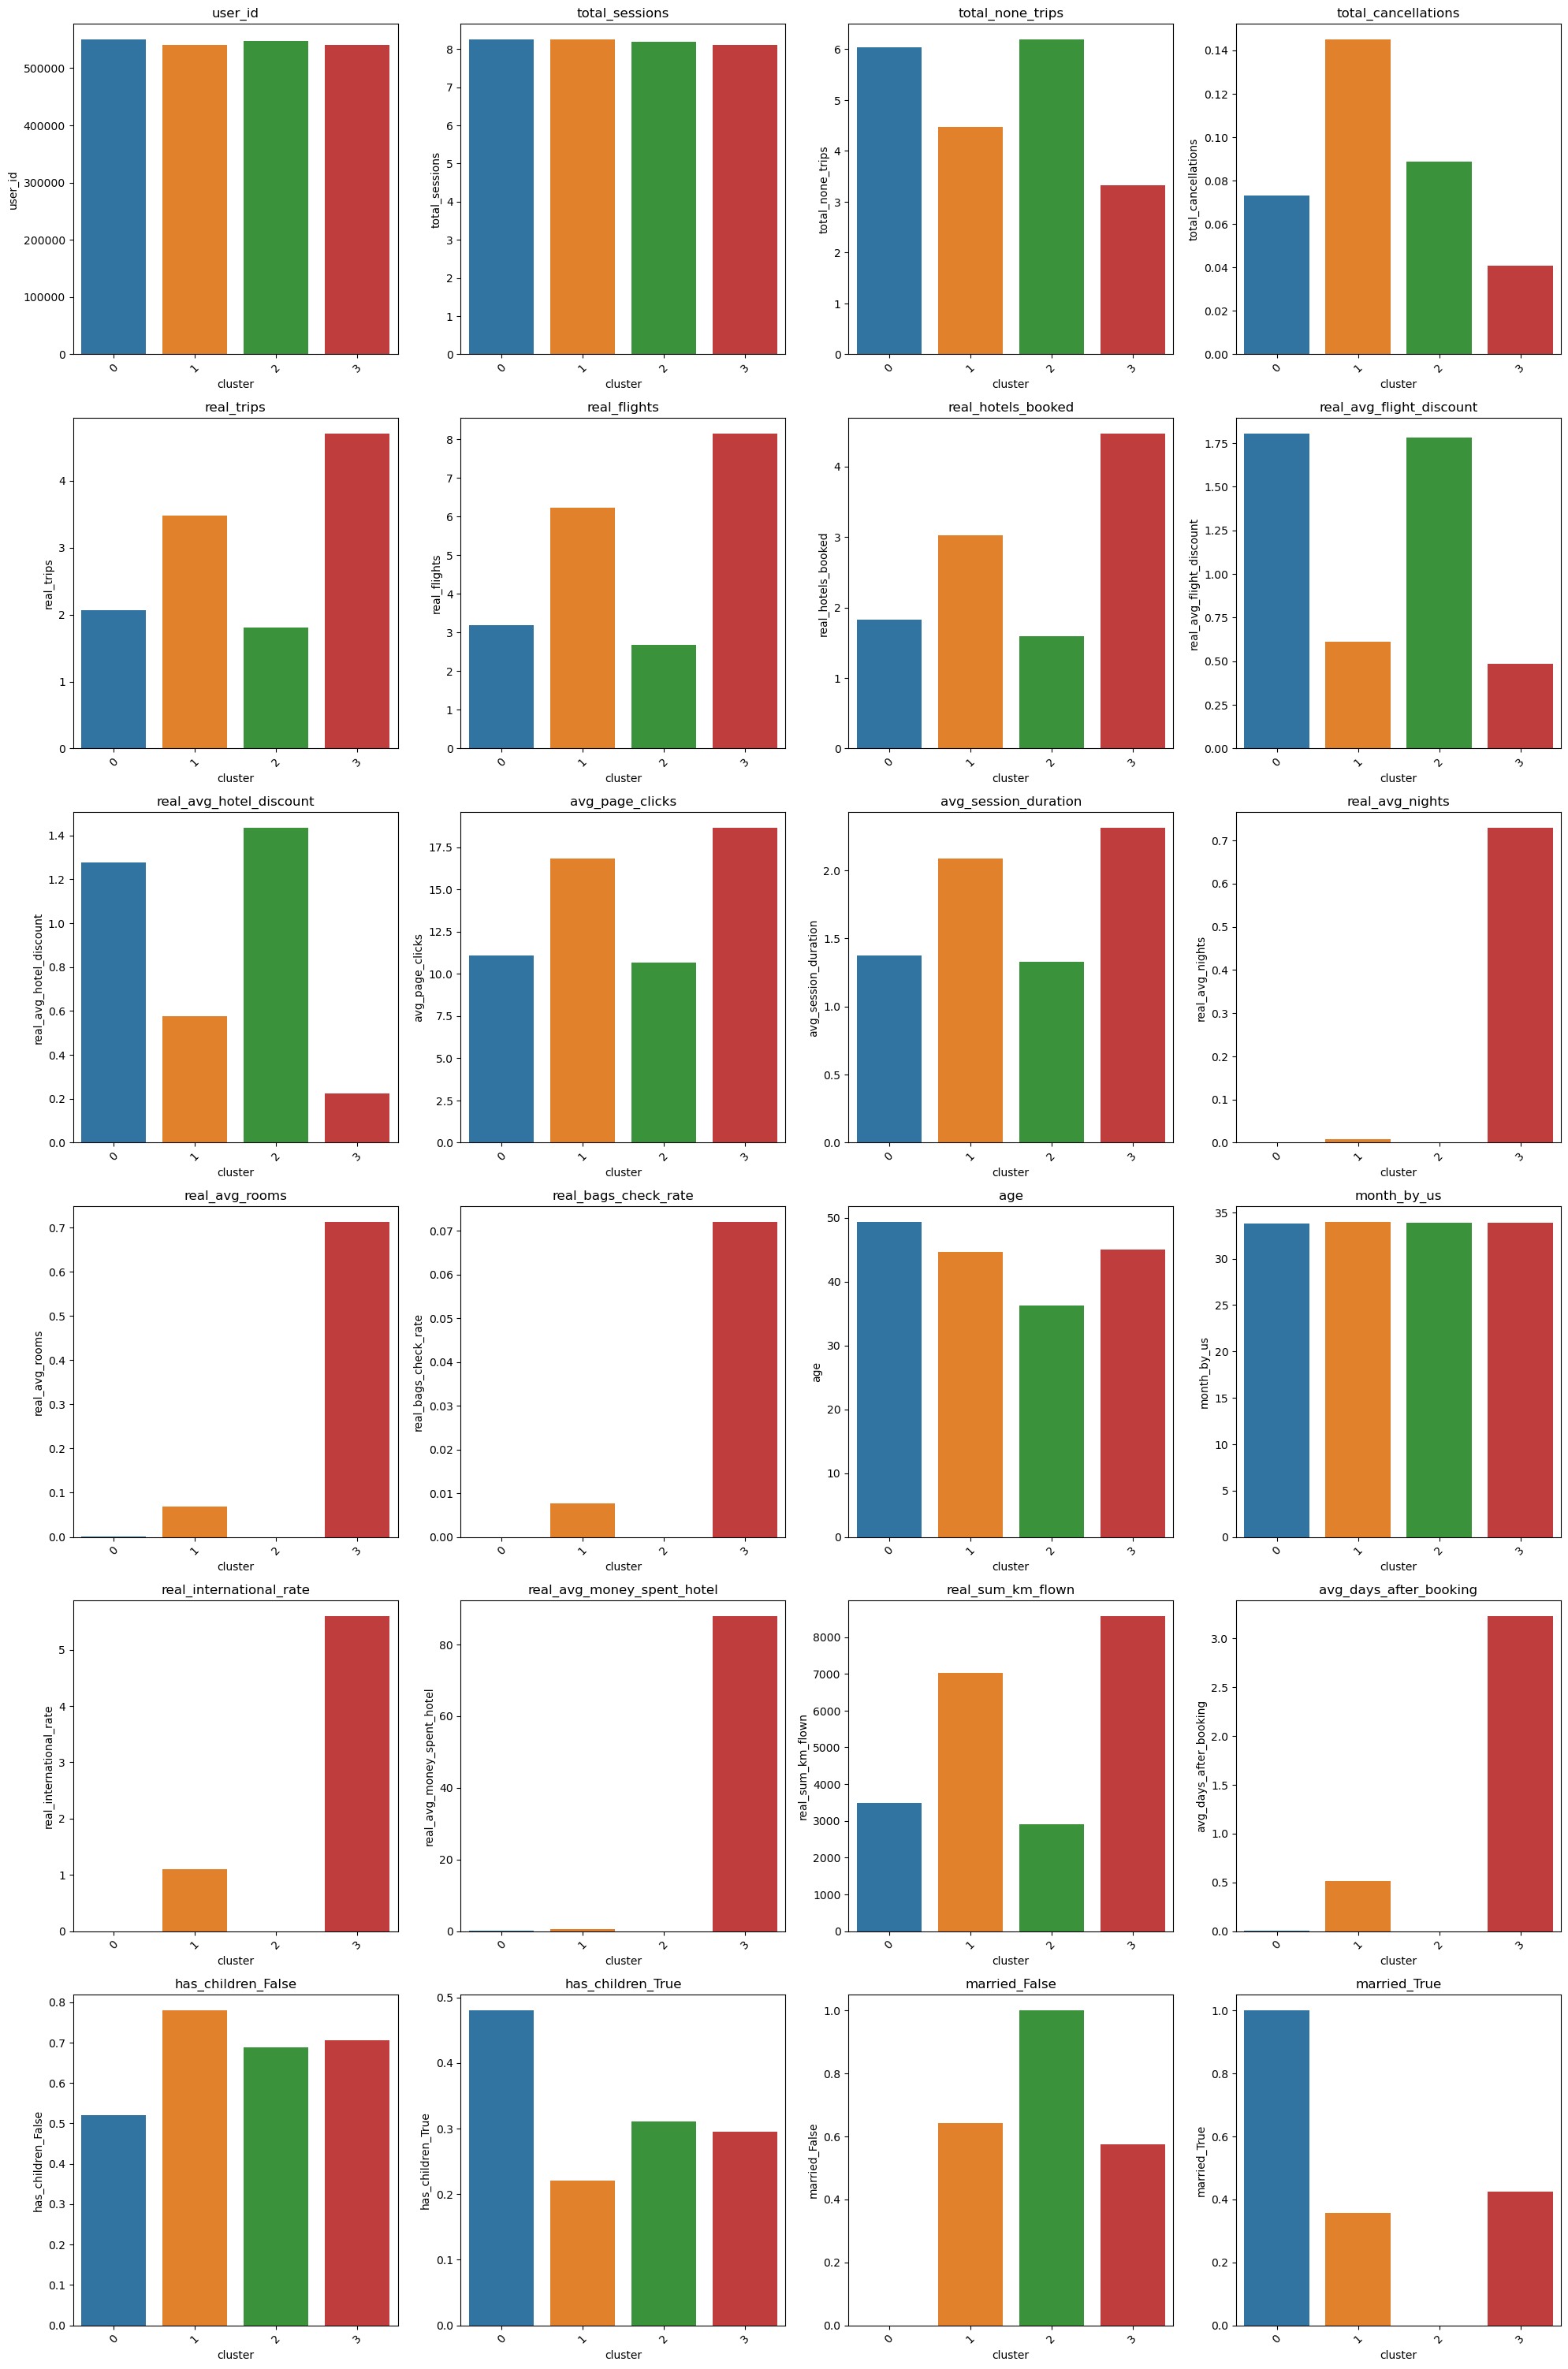

In [102]:

n_cols = 4
n_rows = math.ceil(len(features) / n_cols)
cluster_profiles = pd.concat([features, features_row['cluster']], axis=1) \
                        .groupby('cluster') \
                        .mean()


plt.figure(figsize=(5 * n_cols, 5 * n_rows))
for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i+1)
    sns.barplot(x=cluster_profiles.index, y=cluster_profiles[feature], palette=sns.color_palette("tab10", 4))
    plt.title(feature)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Zusätzliche Visualisierung wichtiger Merkmale

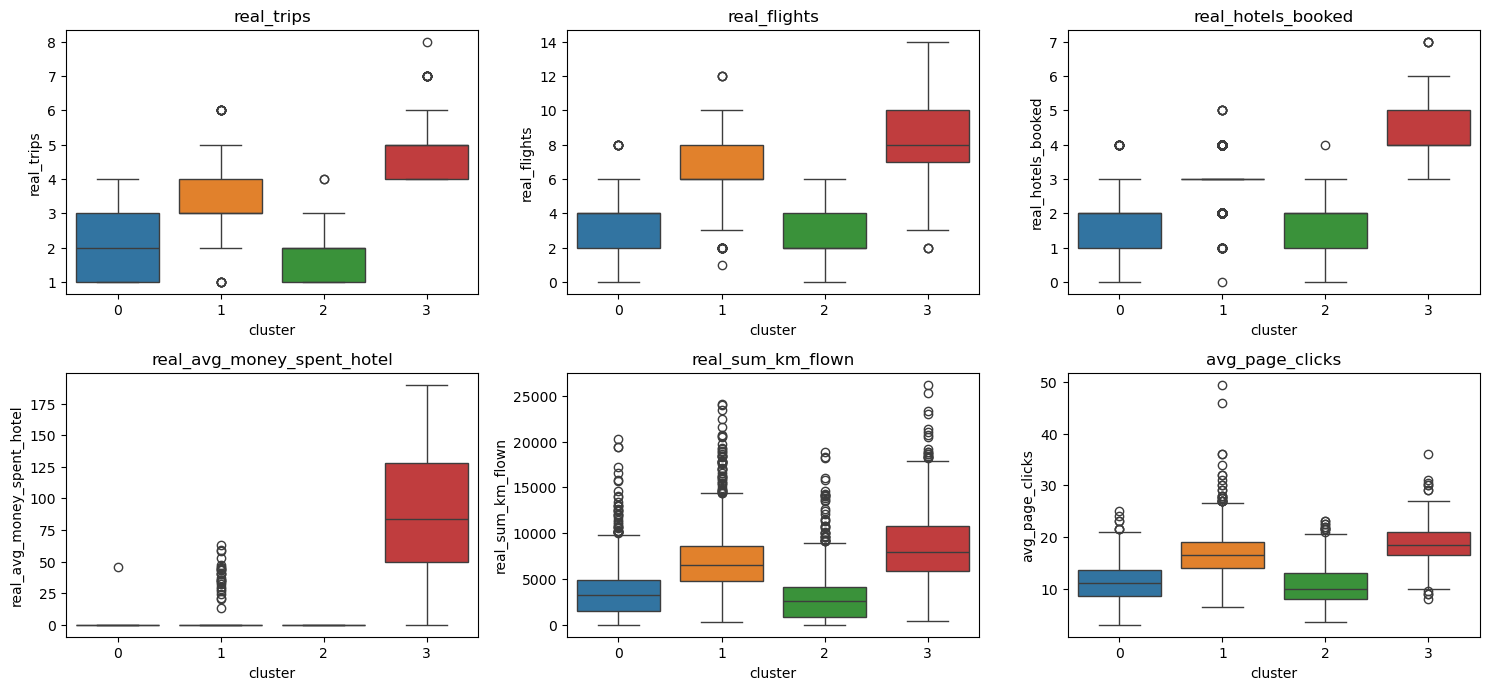

In [103]:
important_features = [
    'real_trips', 'real_flights', 'real_hotels_booked',
    'real_avg_money_spent_hotel', 'real_sum_km_flown', 
    'avg_page_clicks'
]

plt.figure(figsize=(15, 10))
for i, feature in enumerate(important_features):
    plt.subplot(3, 3, i+1)
    sns.boxplot(
        x='cluster', 
        y=feature, 
        data=features_row,
        palette=sns.color_palette("tab10", 4) 
    )
    plt.title(feature)
plt.tight_layout()
plt.show()

In [104]:
mapping = {
    clusters_sorted.loc[0,'Cluster']: 'Familienurlauber',
    clusters_sorted.loc[3,'Cluster']: 'Vielflieger (Geschäftsreisender)',
    clusters_sorted.loc[1,'Cluster']: 'Junge Sparfüchse',
    clusters_sorted.loc[2,'Cluster']: 'Gelegenheitsreisender'
}

features_row['cluster'] = features_row['cluster'].map(mapping)
features_row

,user_id,total_sessions,total_none_trips,total_cancellations,real_trips,real_flights,real_hotels_booked,real_avg_flight_discount,real_avg_hotel_discount,avg_page_clicks,...,real_bags_check_rate,has_children,married,age,month_by_us,real_international_rate,real_avg_money_spent_hotel,real_sum_km_flown,avg_days_after_booking,cluster
0,23557,8,6,0,2,0,2,0.0,12.5,9.0,...,0.0,False,True,66,52,0.0,0.000,0.000000,0.0,Familienurlauber
1,94883,8,6,0,2,4,2,0.0,0.0,5.0,...,0.0,False,True,53,45,0.0,0.000,2907.332255,0.0,Familienurlauber
2,101486,8,6,0,2,2,2,0.0,0.0,19.5,...,0.0,True,True,52,45,0.0,0.000,965.340568,0.0,Familienurlauber
4,118043,8,3,0,5,6,4,0.0,2.5,18.0,...,0.0,True,False,53,44,0.0,185.625,7365.073527,1.0,Vielflieger (Geschäftsreisender)
5,120851,8,7,0,1,2,1,0.0,0.0,6.0,...,0.0,True,True,53,44,0.0,0.000,2249.833872,0.0,Familienurlauber
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5437,785186,8,6,0,2,4,2,0.0,0.0,14.0,...,0.0,True,True,46,31,0.0,0.000,2080.235246,0.0,Familienurlauber
5438,792549,8,4,0,4,8,1,0.0,0.0,15.0,...,0.0,False,False,47,31,0.0,0.000,5751.860879,0.5,Gelegenheitsreisender
5439,796032,8,4,1,2,4,2,0.0,0.0,7.0,...,0.0,False,True,52,31,0.0,0.000,3901.796112,0.0,Familienurlauber
5440,801660,8,5,0,3,6,3,0.0,0.0,15.5,...,0.0,True,True,56,30,0.0,0.000,2163.381356,0.0,Familienurlauber


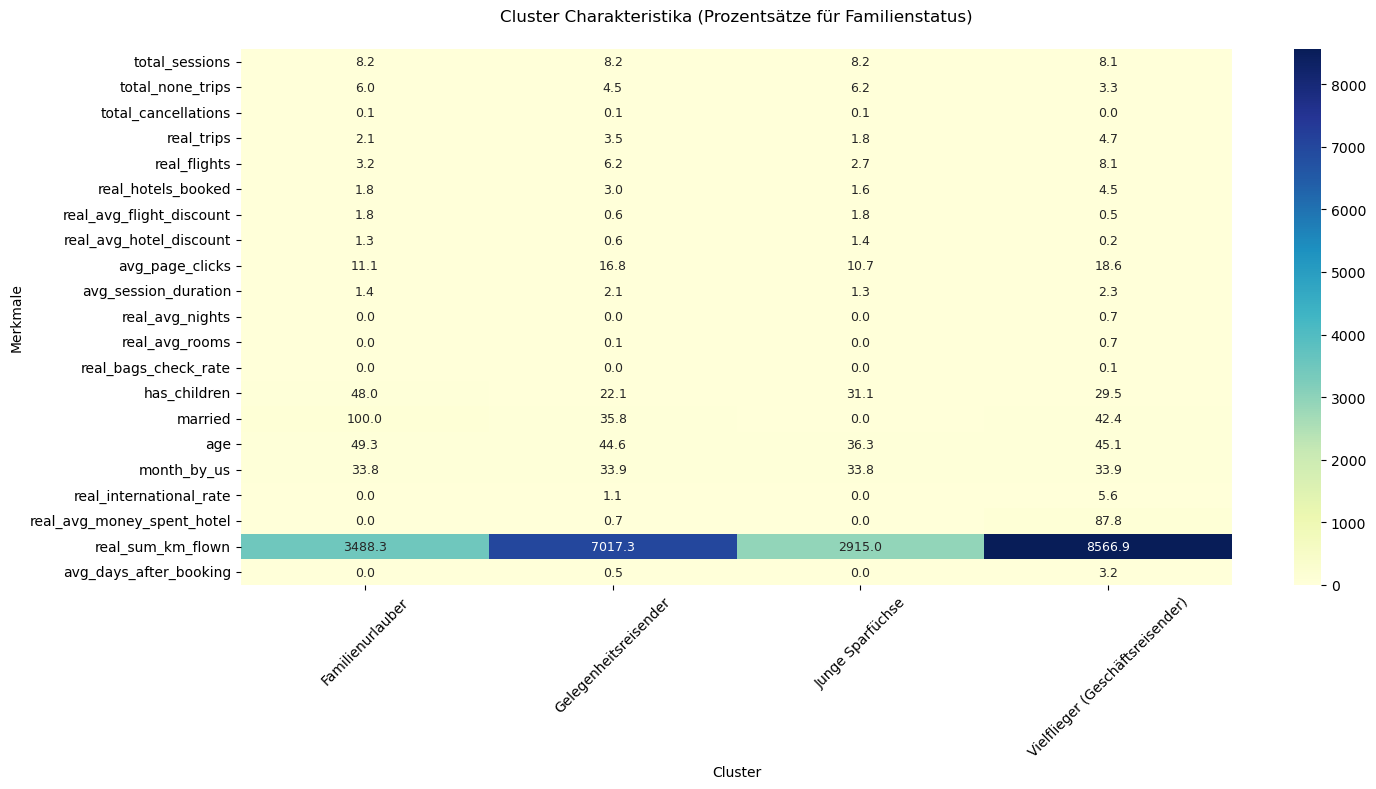

In [105]:
#best_features = X_pca
original_features = features_row[['total_sessions', 'total_none_trips', 'total_cancellations',
       'real_trips', 'real_flights', 'real_hotels_booked',
       'real_avg_flight_discount', 'real_avg_hotel_discount',
       'avg_page_clicks', 'avg_session_duration', 'real_avg_nights',
       'real_avg_rooms', 'real_bags_check_rate', 'has_children', 'married',
       'age', 'month_by_us', 'real_international_rate',
       'real_avg_money_spent_hotel', 'real_sum_km_flown',
       'avg_days_after_booking', 'cluster']]
# Kopie der Originaldaten erstellen
cluster_stats = original_features.copy()

# Für die kategorialen Variablen Prozentsatz berechnen (0-1 Werte)
for col in ['has_children', 'married']:
    cluster_stats[col] = cluster_stats[col].apply(lambda x: 1 if x > 0.5 else 0)

# Gruppieren und Statistiken berechnen
cluster_stats_mean = cluster_stats.groupby('cluster').mean()

# Prozentsätze für die speziellen Spalten berechnen (in %)
cluster_stats_percentage = cluster_stats_mean.copy()
for col in ['has_children', 'married']:
    cluster_stats_percentage[col] = cluster_stats_percentage[col] * 100  # Umwandlung in Prozent

# Heatmap erstellen
plt.figure(figsize=(15, 8))
sns.heatmap(
    cluster_stats_percentage.T, 
    cmap='YlGnBu', 
    annot=True, 
    fmt=".1f",  # Eine Nachkommastelle für Prozentwerte
    annot_kws={'size': 9},
)
plt.title('Cluster Charakteristika (Prozentsätze für Familienstatus)', pad=20)
plt.xlabel('Cluster')
plt.ylabel('Merkmale')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [106]:
X_filter = features_row[['user_id','total_cancellations',
       'real_trips', 'real_flights', 'real_hotels_booked',
       'real_avg_flight_discount', 'real_avg_hotel_discount',
       'avg_page_clicks', 'avg_session_duration', 'real_avg_nights',
       'real_avg_rooms', 'real_bags_check_rate', 'has_children', 'married',
       'age', 'real_international_rate',
       'real_avg_money_spent_hotel', 'real_sum_km_flown',
       'avg_days_after_booking', 'cluster']]

# Entwicklung von Aktionsangeboten für jede Gruppe

## Beschreibung der Cluster und entsprechende Angebote

In [ ]:
cluster_descriptions = {
    clusters_sorted.loc[1,'Cluster']: {
        'Gruppe': 'Junge Sparfüchse',
        'Charakteristika': [
            'Niedrigste Buchungsaktivität (1,8 echte Trips)', 'Hohe Rabatte (1,8% Flug, 1,4% Hotel)',
            'Keine internationale Reisen (0%) und keine Ausgaben für Hotels (0€)',
            'Kurzeste Sitzungsdauer (1,3 Minuten) und am wenigstens Klicks (10,7)',
            'Jung (36,3 Jahre), unverheiratet und meist ohne Kinder (31.1%)',
            'größte Anzahl von leeren Sessions (6.2)',
            'Spontane Buchung (im Duchstnitt 0 Tage vor der Reise)'
        ],
        'Angebot': 'Günstige Last-Minute-Angebote für dich! Spare bis zu 50% auf Flüge und Hotels – perfekt für spontane Trips!'
    },
    clusters_sorted.loc[3,'Cluster']: {
        'Gruppe': 'Vielfliegende Geschäftsreisende',
        'Charakteristika': [
            'Hohe Buchungsaktivität (4,7 echte Trips, 8,1 Flüge, 4,5 Hotels).',
            'Internationale Reisen (5,6%) und hohe Ausgaben (87.8€ für Hotels pro User).',
            'Lange Sitzungsdauer (2,3 Minuten) und viele Klicks (18,6).',
            'Älter (45,1 Jahre), selten verheiratet (42.4%) und ohne Kinder (29.5%).',
            'Buchung lang im Voraus (im Duchstnitt 3.2 Tage vor der Reise)'
        ],
        'Angebot': 'Business-Class-Upgrades und exklusive Hotel-Deals für Vielflieger! Sammle Bonusmeilen und genieße VIP-Service.'
    },
    clusters_sorted.loc[0,'Cluster']: {
        'Gruppe': 'Familien Heimurlauber',
        'Charakteristika': [
            'Mittlere Buchungsaktivität (2,1 Trips, 3,2 Flüge, 1,8 Hotels).',
            'Hohe Rabatte (1,8% bei Flügen).',
            'Verheiratet (100%) und älter (49,3 Jahre), oft mit Kindern (48%).',
            'Keine internationalen Reisen (0%)','Geringe Hotelausgaben (0€)',
            'Spontane Buchung (im Duchstnitt 0 Tage vor der Reise)'
        ],
        'Angebot': 'Familienrabatte bis zu 30% auf All-Inklusive-Pakete + einmalige kostenfreie Umbuchung bis 24 Stunden vor Anreise – sorgloser Urlaub für die ganze Familie.'
    },
    clusters_sorted.loc[2,'Cluster']: {
        'Gruppe': 'Gelegenheitsreisende',
        'Charakteristika': [
            'Ausgewogenes Verhalten (3,5 Trips, 6,2 Flüge, 3 Hotels).',
            'Mittlere Rabatte (0,6% bei Flügen, 0,6% bei Hotels) und internationale Reisen (1,1%).',
            'Durchschnittsalter (44,6 Jahre), teilweise verheiratet (35.8%).',
            'Planung bei der Buchung (im Duchstnitt 0.5 Tage vor der Reise)',
            'längere Sessions (2.1 Min) und viele Klicks (16.9)'
        ],
        'Angebot': 'Kombi-Deals für deinen nächsten Kurzurlaub! Flug + Hotel zum Festpreis – flexibel und budgetfreundlich.'
    }
}

# Ausgabe der Clusterbeschreibungen und Angebote
print("\nKundencluster und Aktionsangebote:")
for cluster_num, desc in cluster_descriptions.items():
    print(f"\nCluster {cluster_num}: {desc['Gruppe']}")
    print("Charakteristika:")
    for char in desc['Charakteristika']:
        print(f"- {char}")
    print(f"Spezielles Angebot: {desc['Angebot']}")





Kundencluster und Aktionsangebote:

Cluster 0: Junge Sparfüchse
Charakteristika:
- Niedrigste Buchungsaktivität (1,8 echte Trips)
- Hohe Rabatte (1,8% Flug, 1,4% Hotel)
- Keine internationale Reisen (0%) und keine Ausgaben für Hotels (0€)
- Kurzeste Sitzungsdauer (1,3 Minuten) und am wenigstens Klicks (10,7)
- Jung (36 Jahre), unverheiratet und meist ohne Kinder (31.2%)
- größte Anzahl von leeren Sessions (6.2)
- Spontane Buchung (im Duchstnitt 0 Tage vor der Reise)
Spezielles Angebot: Günstige Last-Minute-Angebote für dich! Spare bis zu 50% auf Flüge und Hotels – perfekt für spontane Trips!

Cluster 3: Vielfliegende Geschäftsreisende
Charakteristika:
- Hohe Buchungsaktivität (4,7 echte Trips, 8,1 Flüge, 4,5 Hotels).
- Internationale Reisen (5,6%) und hohe Ausgaben (87.8€ für Hotels pro User).
- Lange Sitzungsdauer (2,3 Minuten) und viele Klicks (18,6).
- Älter (44,7 Jahre), oft unverheiratet (42.4%) und ohne Kinder (29.5%).
- Buchung lang im Voraus (im Duchstnitt 3.2 Tage vor der Rei